# Spatial Data Assimilation in Geologic CO2 Sequestration
## Misael M. Morales - Summer 2023 - LANL

In [2]:
# Load packages, class, and functions
from utils import *
sda = spatialDA()
sda.check_torch_gpu()
octave = sda.mrst_startup()

-------------------------------------------------
------------------ VERSION INFO -----------------
Conda Environment: torchy | Python version: 3.8.16 (default, Mar  2 2023, 03:18:16) [MSC v.1916 64 bit (AMD64)]
Torch version: 2.0.1
Torch build with CUDA? True
# Device(s) available: 1, Name(s): Quadro P520

Welcome to the MATLAB Reservoir Simulation Toolbox (MRST)!
You are using the release version 2023a. To download other versions of MRST
and view examples and relevant publications, please visit www.mrst.no

Useful commands for getting started:
 - List all introductory examples:   mrstExamples()
 - List all modules:                 mrstPath('list')
 - Load modules using GUI:           mrstModule('gui')
 - Explore all available data sets:  mrstDatasetGUI()
 - List examples of a module:        mrstExamples('ad-blackoil')
 - Explore modules and publications: mrstExploreModules()
 - Show all examples in all modules: mrstExamples('all')
 - Show settings for MRST:           mrstSettings()
 

True Perm: (2601,) | True Saturation: (3, 2601)
Perm Ensemble: (100, 2601)
Perm All shape: (101, 2601)


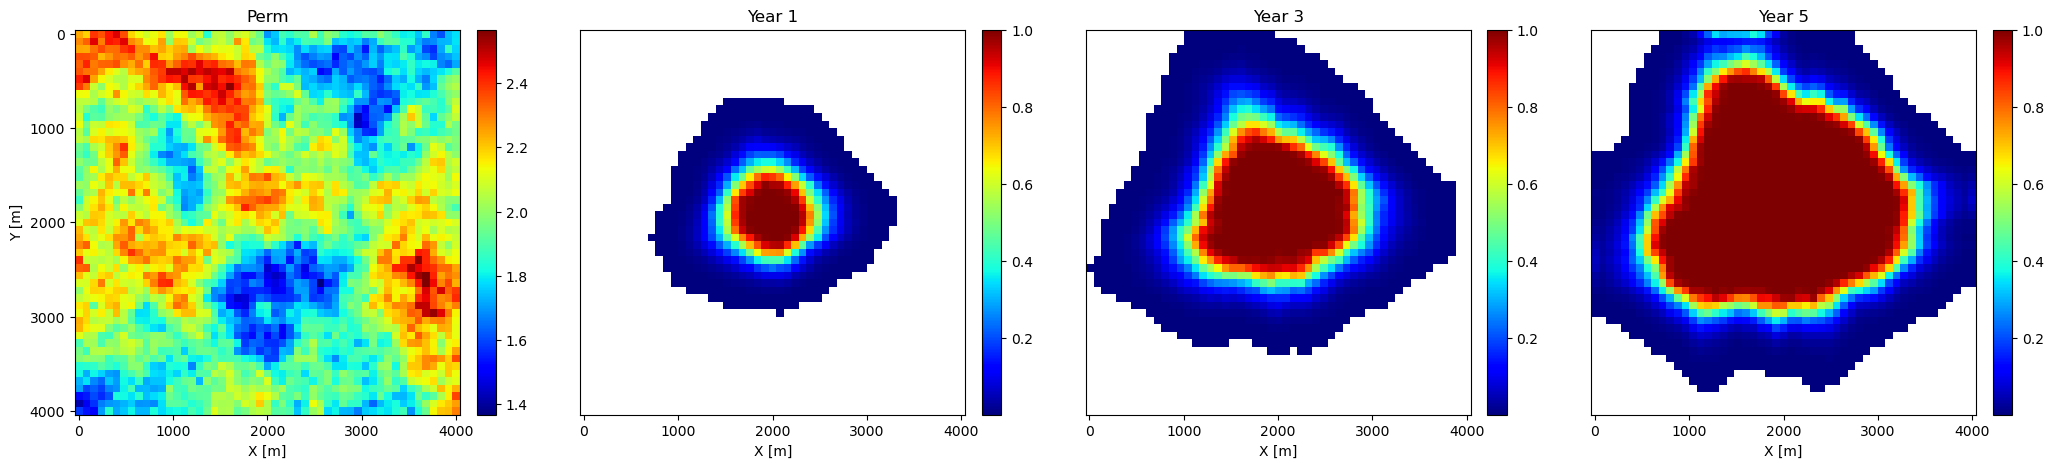

In [3]:
# Load permeability (true, ensemble) and saturation (true)
perm_true, sat_true = sda.load_perm_sat_true()
perm_ens            = sda.load_perm_ens()
perm_all            = sda.load_perm_all()
sda.plot_perm_sat(perm_true, sat_true)

In [4]:
# Reservoir Simulation of the permeability ensemble
n_realizations = 2
saturation = {}
for i in range(n_realizations):
    saturation[i] = octave.feval('simulations_octave/sim', perm_all[i])

Solving timestep 1/8:         -> 45 Days, 15 Hours, 2619.00 Seconds
Solving timestep 2/8: 45 Days, 15 Hours, 2619.00 Seconds -> 91 Days, 7 Hours, 1638.00 Seconds
Solving timestep 3/8: 91 Days, 7 Hours, 1638.00 Seconds -> 182 Days, 14 Hours, 3276.00 Seconds
Solving timestep 4/8: 182 Days, 14 Hours, 3276.00 Seconds -> 1 Year
Solving timestep 5/8: 1 Year  -> 2 Years
Solving timestep 6/8: 2 Years -> 3 Years
Solving timestep 7/8: 3 Years -> 4 Years
Solving timestep 8/8: 4 Years -> 5 Years
*** Simulation complete. Solved 8 control steps in 30 Seconds, 805 Milliseconds ***
Solving timestep 1/8:         -> 45 Days, 15 Hours, 2619.00 Seconds
Solving timestep 2/8: 45 Days, 15 Hours, 2619.00 Seconds -> 91 Days, 7 Hours, 1638.00 Seconds
Solving timestep 3/8: 91 Days, 7 Hours, 1638.00 Seconds -> 182 Days, 14 Hours, 3276.00 Seconds
Solving timestep 4/8: 182 Days, 14 Hours, 3276.00 Seconds -> 1 Year
Solving timestep 5/8: 1 Year  -> 2 Years
Solving timestep 6/8: 2 Years -> 3 Years
Solving timestep 7/8

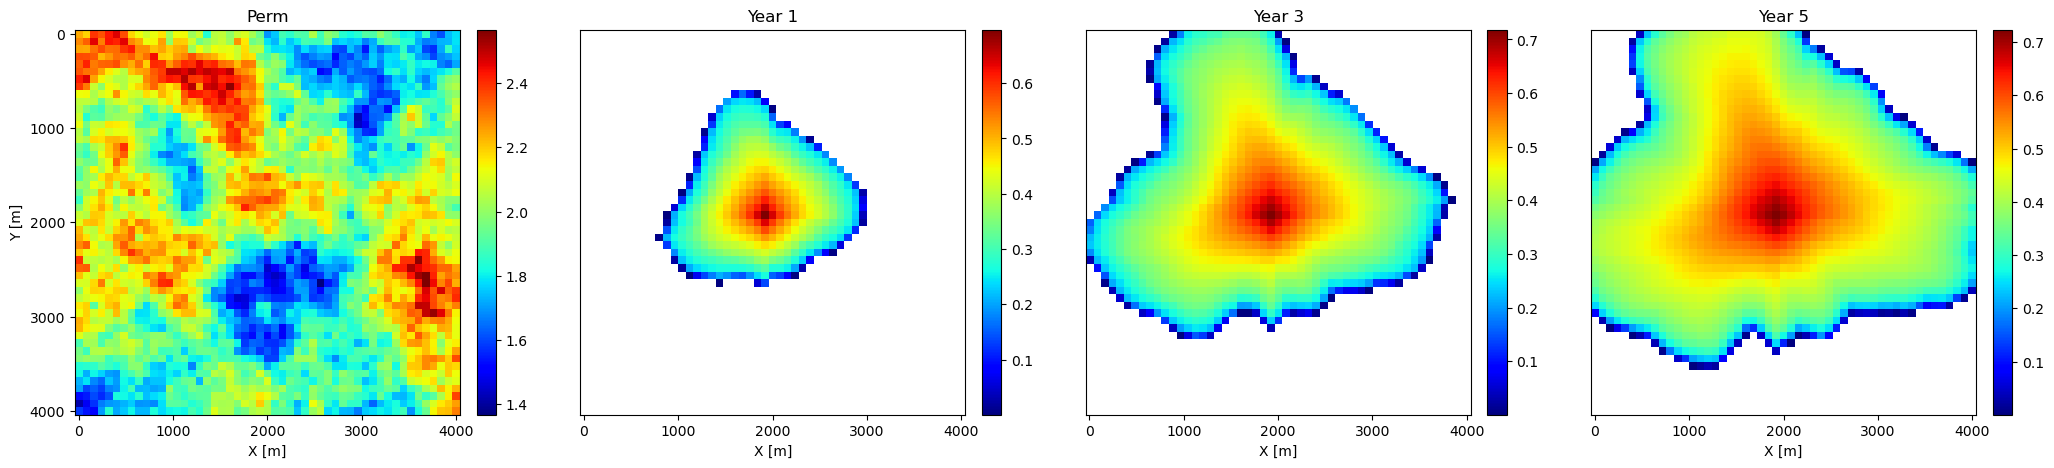

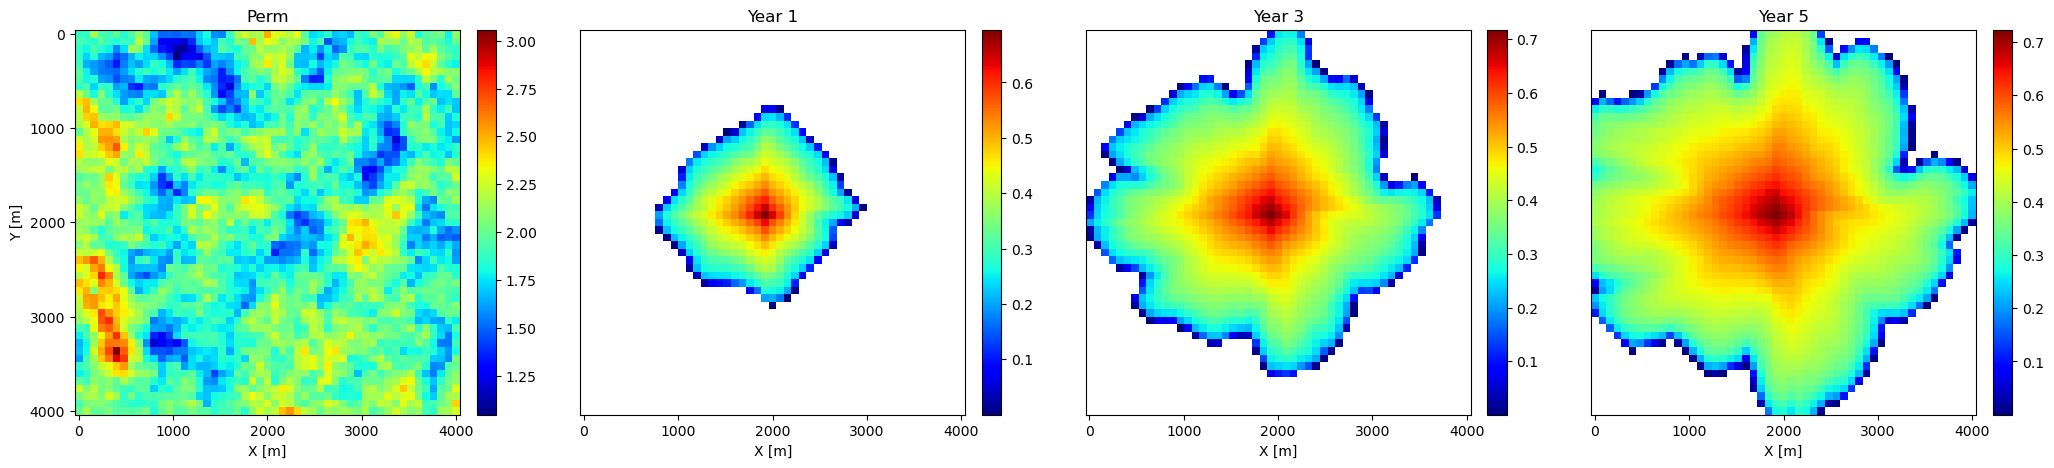

In [20]:
for i in range(n_realizations):
    sda.plot_perm_sat(perm_all[i], saturation[i])

***
# ESMDA-GEO

In [109]:
def forward_model(m_ensemble):
    d_pred = np.zeros([100, sda.dim*sda.dim])
    for i in range(m_ensemble.shape[0]):
        d_pred[i,:] = octave.feval('simulations_octave/sim', m_ensemble[i])[0]
    return d_pred

In [137]:
# Observations
obs = sat_true[0].reshape(-1,1)
cov_obs = approximate_cov_mm(perm_ens)

# Ensemble
n_ensemble = 100
m_ensemble = perm_ens

In [138]:
n_assimilations = 2

cov_obs_inflation_geo = 1.2
cov_obs_inflation_factors = [1.1]

for l in range(1, n_assimilations):
    cov_obs_inflation_factors.append(cov_obs_inflation_factors[l - 1] / cov_obs_inflation_geo)
scaling_factor = np.sum(1/np.array(cov_obs_inflation_factors))
cov_obs_inflation_factors = [alpha * scaling_factor for alpha in cov_obs_inflation_factors]
print('cov_obs_inflation_factors:', cov_obs_inflation_factors)

cov_mm_inflation_factors = [1.2] * n_assimilations
print('cov_mm_inflation_factors: ', cov_mm_inflation_factors)

cov_obs_inflation_factors: [2.2, 1.8333333333333335]
cov_mm_inflation_factors:  [1.2, 1.2]


In [134]:
m_ensemble.shape

(100, 2601)

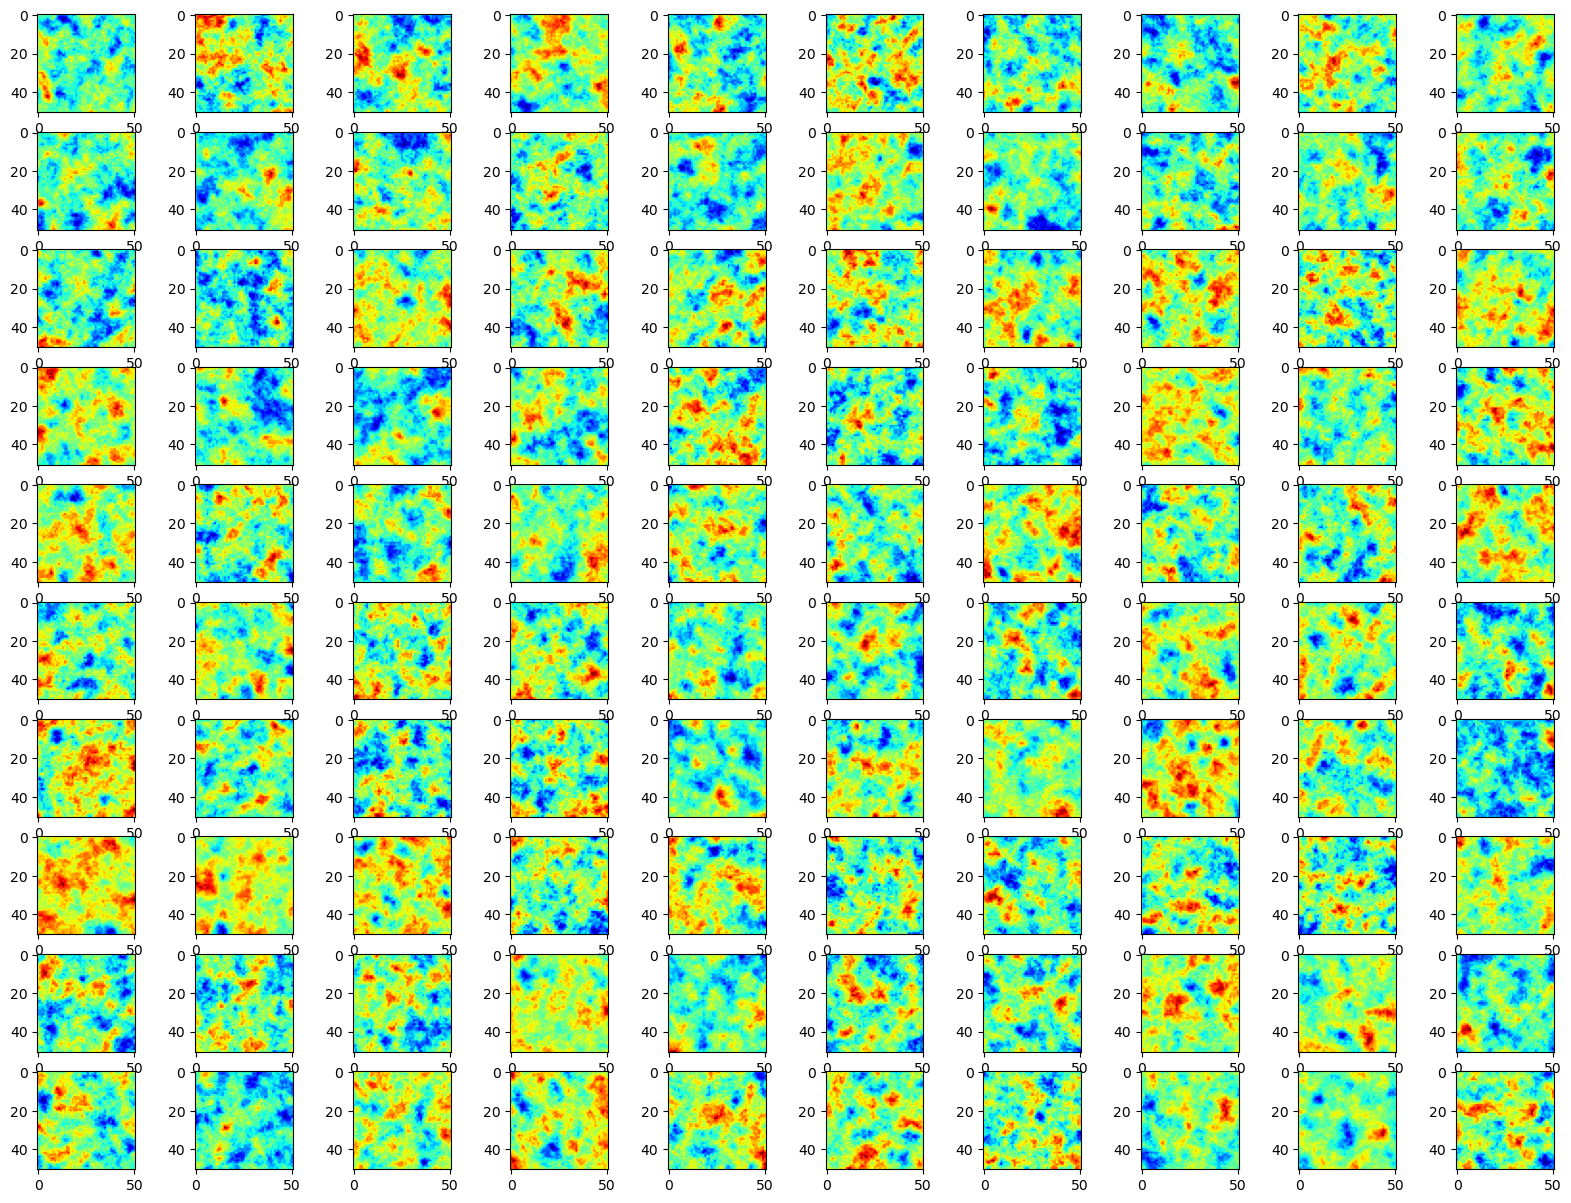

In [144]:
k=0
fig, axs =plt.subplots(10,10,figsize=(20,15))
for i in range(10): 
    for j in range(10):
        axs[i,j].imshow(solver.m_prior[k].reshape(51,51), 'jet')
        k += 1

In [132]:
solver = ESMDA(obs, m_ensemble, cov_obs, forward_model, 
               forward_model_args        = (),
               forward_model_kwargs      = {},
               n_assimilations           = n_assimilations,
               cov_obs_inflation_factors = cov_obs_inflation_factors,
               cov_mm_inflation_factors  = cov_mm_inflation_factors,
               save_ensembles_history    = True)
solver.solve()

#approxtimate parameters


Assimilation # 1
Solving timestep 1/8:         -> 45 Days, 15 Hours, 2619.00 Seconds
Solving timestep 2/8: 45 Days, 15 Hours, 2619.00 Seconds -> 91 Days, 7 Hours, 1638.00 Seconds
Solving timestep 3/8: 91 Days, 7 Hours, 1638.00 Seconds -> 182 Days, 14 Hours, 3276.00 Seconds
Solving timestep 4/8: 182 Days, 14 Hours, 3276.00 Seconds -> 1 Year
Solving timestep 5/8: 1 Year  -> 2 Years
Solving timestep 6/8: 2 Years -> 3 Years
Solving timestep 7/8: 3 Years -> 4 Years
Solving timestep 8/8: 4 Years -> 5 Years
*** Simulation complete. Solved 8 control steps in 30 Seconds, 285 Milliseconds ***
Solving timestep 1/8:         -> 45 Days, 15 Hours, 2619.00 Seconds
Solving timestep 2/8: 45 Days, 15 Hours, 2619.00 Seconds -> 91 Days, 7 Hours, 1638.00 Seconds
Solving timestep 3/8: 91 Days, 7 Hours, 1638.00 Seconds -> 182 Days, 14 Hours, 3276.00 Seconds
Solving timestep 4/8: 182 Days, 14 Hours, 3276.00 Seconds -> 1 Year
Solving timestep 5/8: 1 Year  -> 2 Years
Solving timestep 6/8: 2 Years -> 3 Years
Sol

ValueError: The ensemble should be 2D matrices with equal first dimension!

In [ ]:
d = {}
for i in range(100):
    d[i] = exponential([m_ensemble[i,0], m_ensemble[i,1]], x)
    
plt.plot(x, obs, label='$d_{obs}$')
for i in range(100):
    plt.plot(x, d[i], alpha=0.3, c='cyan')
plt.plot(x, exponential([a,b], x), c='k', linewidth=3, linestyle='-', label='true')
plt.plot(x, exponential([a_approx,b_approx], x), c='r', linewidth=3, linestyle='--', label='posterior')
plt.legend(); plt.grid('on')
plt.show()

***
# END